In [8]:
import numpy as np
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.applications import VGG16
from PIL import Image

In [9]:
def compile_train_plot_conf(network, tr_gen, val_gen):
    network.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(learning_rate=1e-4),
                    metrics=['acc'])
    history = model.fit(
        tr_gen,
        steps_per_epoch=50,
        epochs=30,
        validation_data=val_gen,
        validation_steps=50,
        workers=-1)
    print(history.history.keys())

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'yo', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [10]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)

test_dir = 'chest_xray/test'
train_dir = 'chest_xray/train'
validation_dir = 'chest_xray/val'

img_dim = 256

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_dim, img_dim),
    batch_size=20,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_dim, img_dim),
    batch_size=20,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Basic Model

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),
                        activation='relu',
                        input_shape=(img_dim, img_dim, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 128)     

Epoch 1/30
50/50 [==============================] - 19s 359ms/step - loss: 0.5224 - acc: 0.7720 - val_loss: 0.8033 - val_acc: 0.5625
Epoch 2/30
50/50 [==============================] - 18s 351ms/step - loss: 0.2664 - acc: 0.8970
Epoch 3/30
50/50 [==============================] - 18s 360ms/step - loss: 0.1726 - acc: 0.9400
Epoch 4/30
50/50 [==============================] - 19s 367ms/step - loss: 0.1820 - acc: 0.9400
Epoch 5/30
50/50 [==============================] - 18s 364ms/step - loss: 0.1335 - acc: 0.9488
Epoch 6/30
50/50 [==============================] - 18s 361ms/step - loss: 0.1265 - acc: 0.9560
Epoch 7/30
50/50 [==============================] - 18s 358ms/step - loss: 0.1192 - acc: 0.9520
Epoch 8/30
50/50 [==============================] - 17s 344ms/step - loss: 0.0964 - acc: 0.9640
Epoch 9/30
50/50 [==============================] - 18s 361ms/step - loss: 0.0986 - acc: 0.9630
Epoch 10/30
50/50 [==============================] - 18s 366ms/step - loss: 0.1140 - acc: 0.9600
Ep

ValueError: x and y must have same first dimension, but have shapes (30,) and (1,)

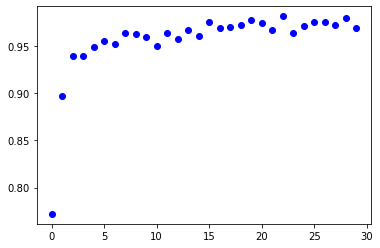

In [12]:
compile_train_plot_conf(network=model, tr_gen=train_generator, val_gen=validation_generator)

# Basic Model + Augmentation

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.3,
    fill_mode='nearest')
# no Horizontal Flip :)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator_datagen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_dim, img_dim),
    batch_size=32,
    class_mode='binary')

validation_generator_datagen = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_dim, img_dim),
    batch_size=32,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
compile_train_plot_conf(network=model, tr_gen=train_generator_datagen, val_gen=validation_generator_datagen)

Epoch 1/30
46/50 [==========================>...] - ETA: 2s - loss: 0.5637 - acc: 0.7289

KeyboardInterrupt: 

# VGG16 + Augmentation (Transfer Learning)


In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_dim, img_dim, 3))

conv_base.summary()

In [34]:
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [35]:
compile_train_plot_conf(network=model, tr_gen=train_generator, val_gen=validation_generator)

Epoch 1/30
43/50 [========================>.....] - ETA: 11s - loss: 0.4333 - acc: 0.8302

KeyboardInterrupt: 

# Fine tuning


In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
compile_train_plot_conf(network=model, tr_gen=train_generator, val_gen=validation_generator)

# Testing on image not from dataset

In [61]:
img = Image.open("self_chest_xray.png").convert("RGB")
img = img.resize((img_dim, img_dim))
img_arr = np.array(img)
img_arr = img_arr.reshape((1,) + img_arr.shape)
model.predict(img_arr)

1/1 [==============================] - 0s 114ms/step


array([[1.]], dtype=float32)